In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
import numpy as np
sns.set(style="whitegrid")

### Comparison of word choice metrics

In [2]:
root = '/data0/lucy/ingroup_lang/'

In [3]:
count_cut_off = 0
pmi_cut_off = 0.8
tfidf_cut_off = 5

In [4]:
def metric_correlation(metric1, metric2, sr_f, path1, path2): 
    df1 = pd.read_csv(path1 + sr_f, engine='python')
    df2 = pd.read_csv(path2 + sr_f, engine='python')
    df = pd.merge(df1, df2, on='word', how='outer')
    p = sns.scatterplot(x=metric1, y=metric2, data=df)
    print(stats.pearsonr(df[metric1], df[metric2]))
    plt.title(sr_f)
    plt.show()
def metric_correlation_generic(metric1, metric2, path1, path2, join_on, title, ylog=False, ylim=None): 
    df1 = pd.read_csv(path1, engine='python')
    df2 = pd.read_csv(path2, engine='python')
    df = pd.merge(df1, df2, on=join_on, how='outer')
    p = sns.scatterplot(x=metric1, y=metric2, data=df)
    print(stats.pearsonr(df[metric1], df[metric2]))
    if ylog: 
        plt.yscale('log')
    if ylim: 
        plt.ylim(ylim)
    plt.title(title)
    plt.show()

(0.8900561729211842, 0.0)


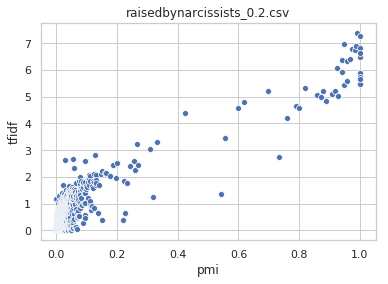

In [5]:
metric_correlation('pmi', 'tfidf', 'raisedbynarcissists_0.2.csv', root + 'logs/pmi/', root + 'logs/tfidf/')

(0.6411539121291642, 0.0)


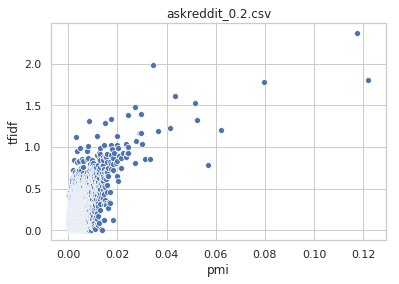

In [6]:
metric_correlation('pmi', 'tfidf', 'askreddit_0.2.csv', root + 'logs/pmi/', root + 'logs/tfidf/')

### Comparison of user metrics

(0.21344521958285165, 2.746722412289928e-06)


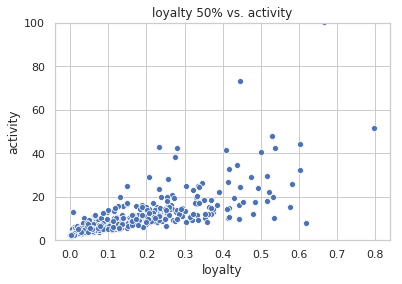

In [7]:
# for different thresholds, the pearson corr is still around 0.22
# however there are subreddits with similar levels of activity but different loyalty
threshold = 50
commentor_path1 = root + 'logs/commentor_loyalty_'+str(threshold)
commentor_path2 = root + 'logs/commentor_activity'
metric_correlation_generic('loyalty', 'activity', commentor_path1, commentor_path2, 
                           'subreddit', 'loyalty ' + str(threshold) + '% vs. activity', ylim=(0,100))

(0.47110993439816284, 1.4687530397481171e-27)


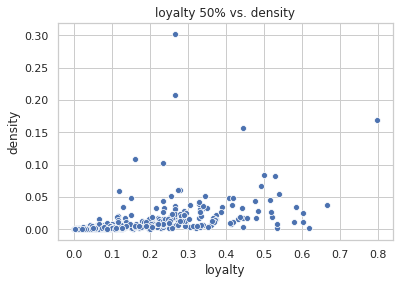

In [8]:
threshold = 50
commentor_path1 = root + 'logs/commentor_loyalty_'+str(threshold)
commentor_path2 = root + 'logs/commentor_density'
metric_correlation_generic('loyalty', 'density', commentor_path1, commentor_path2, 
                           'subreddit', 'loyalty ' + str(threshold) + '% vs. density')

### Word choice vs. word frequency

In [9]:
def metric_vs_frequency(metric_name, path, n): 
    # generate plot for 10 subreddits
    i = 0
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        df = pd.read_csv(path + f, engine='python')
        df = df[df['count'] > count_cut_off]
        p = sns.scatterplot(x='count', y=metric_name, data=df)
        p.figure.get_axes()[0].set_xscale('log')
        plt.title(f)
        plt.show()
        i += 1
        if i > n: break

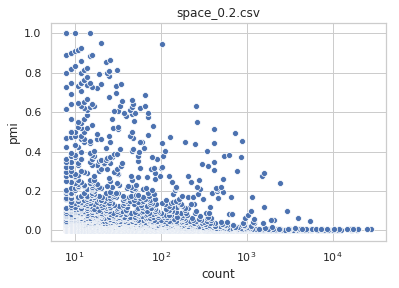

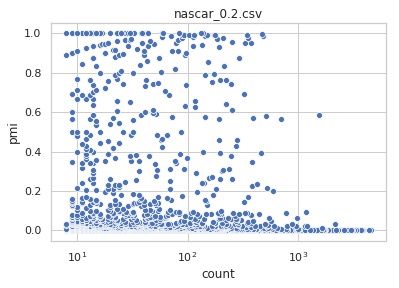

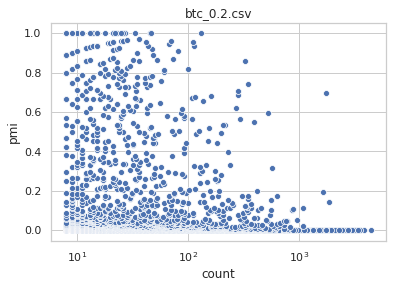

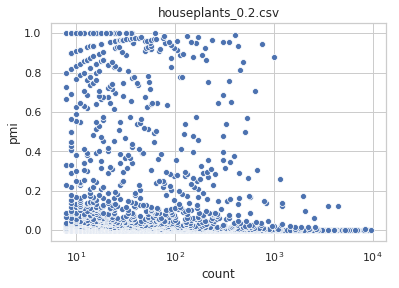

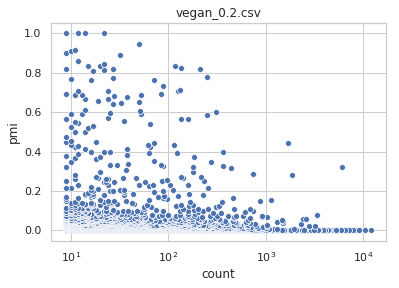

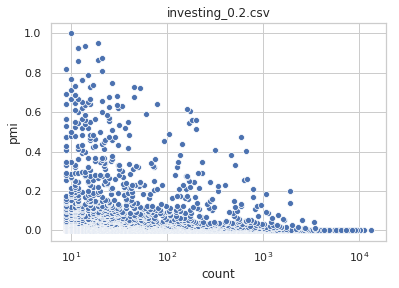

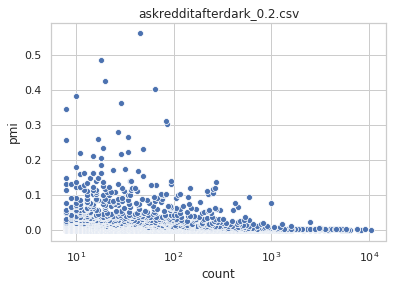

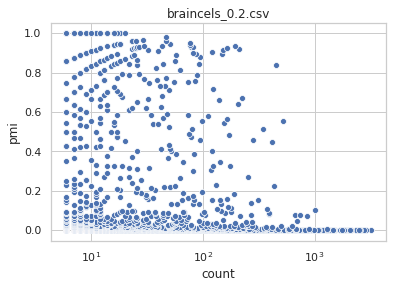

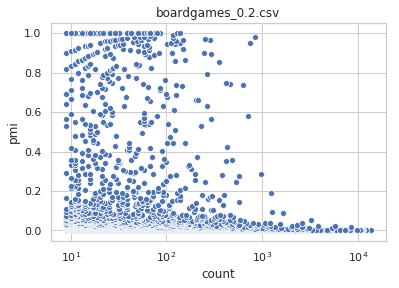

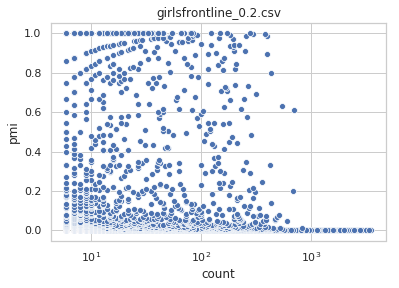

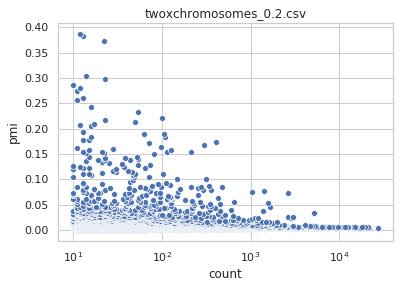

In [10]:
metric_vs_frequency('pmi', root + 'logs/pmi/', 10)

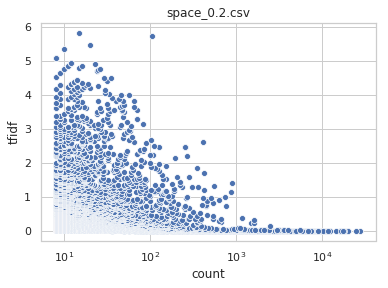

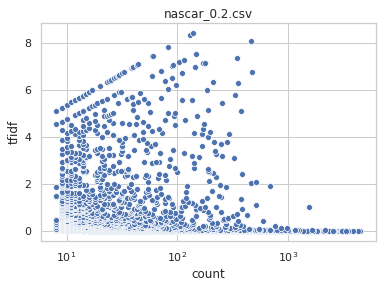

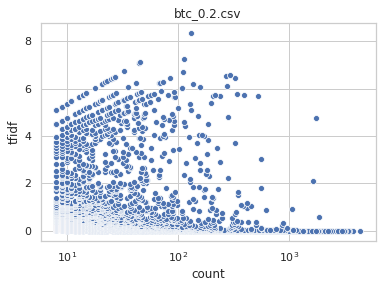

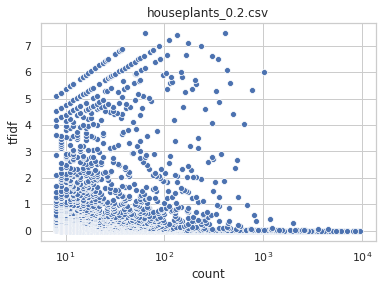

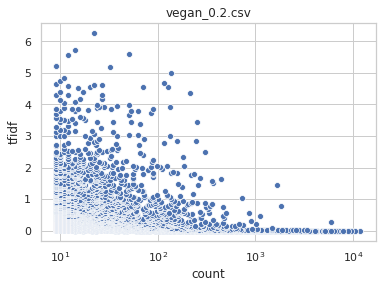

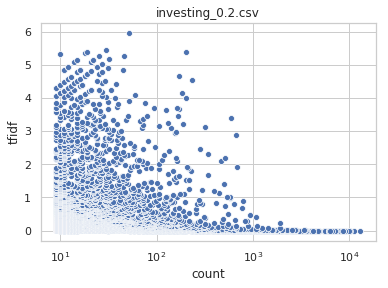

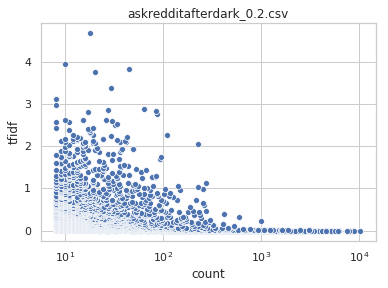

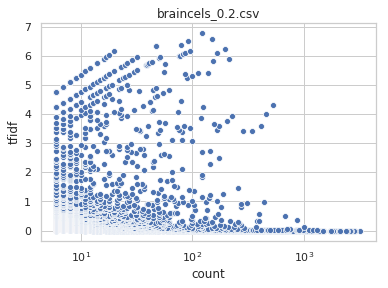

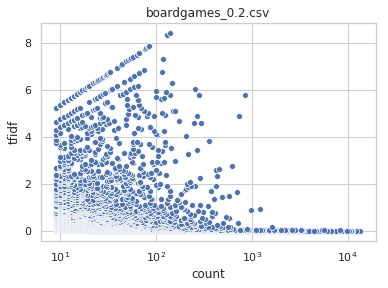

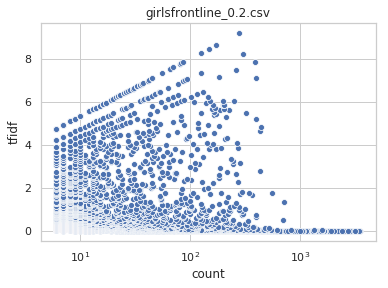

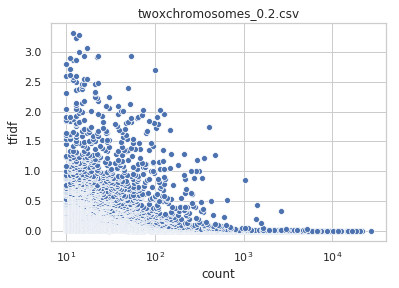

In [11]:
metric_vs_frequency('tfidf', root + 'logs/tfidf/', 10)

In [12]:
def single_metric_vs_frequency(sr_f, metric_name, path): 
    df = pd.read_csv(path + sr_f, engine='python')
    df = df[df['count'] > count_cut_off]
    p = sns.scatterplot(x='count', y=metric_name, data=df)
    p.figure.get_axes()[0].set_xscale('log')
    plt.title(sr_f)
    plt.show()

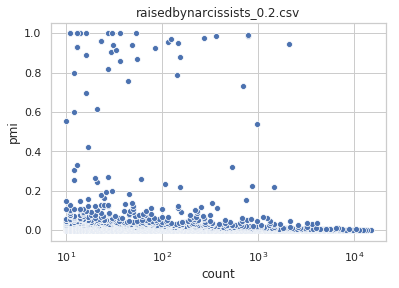

In [13]:
# Look at a single subreddit
single_metric_vs_frequency('raisedbynarcissists_0.2.csv', 'pmi', root + 'logs/pmi/')

### Histogram of word choice values

In [14]:
def word_choice_hist(metric_name, path, n): 
    i = 0
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        df = pd.read_csv(path + f, engine='python')
        df = df[df['count'] > count_cut_off]
        p = sns.distplot(a=df[metric_name], kde=False)
        plt.yscale('log')
        plt.ylabel('# of words')
        plt.title(f)
        plt.show()
        i += 1
        if i > n: break

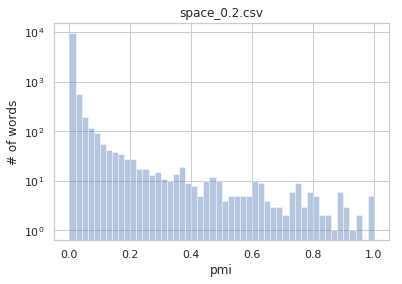

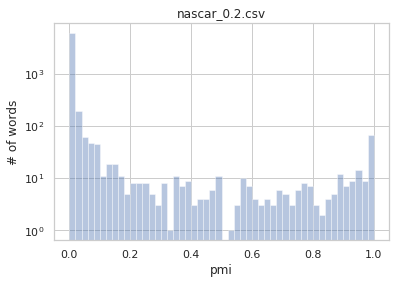

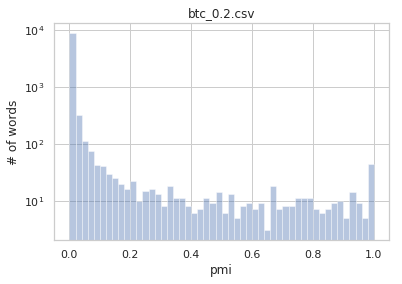

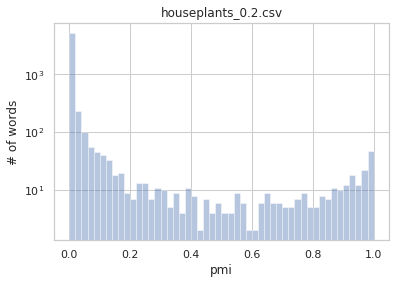

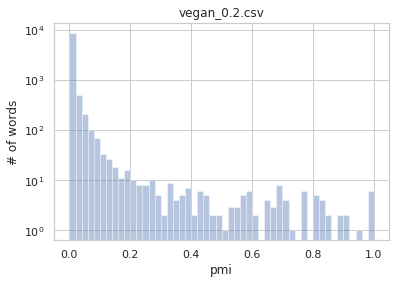

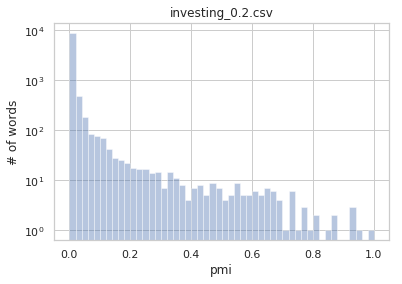

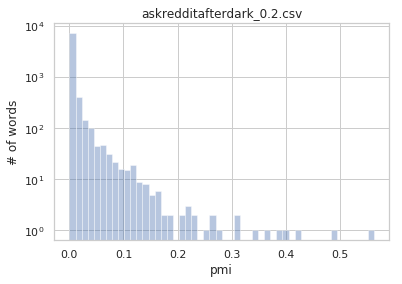

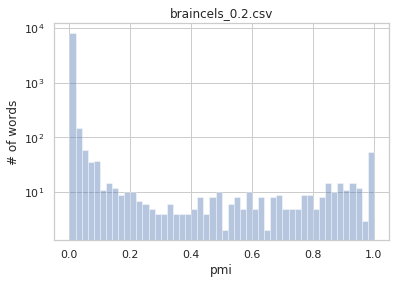

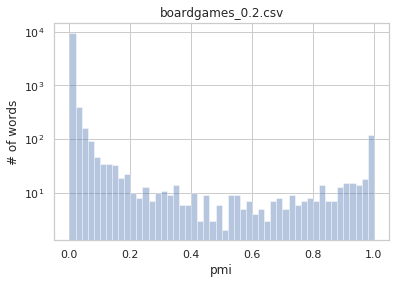

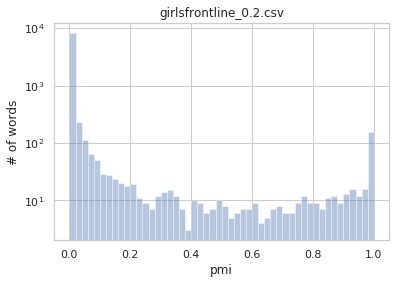

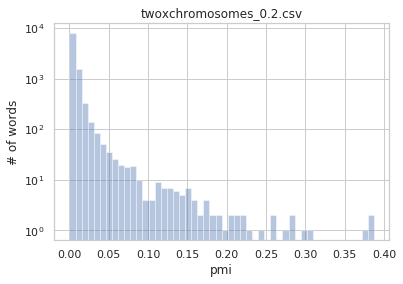

In [15]:
word_choice_hist('pmi', root+'/logs/pmi/', 10)

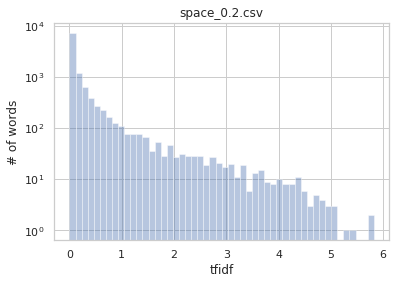

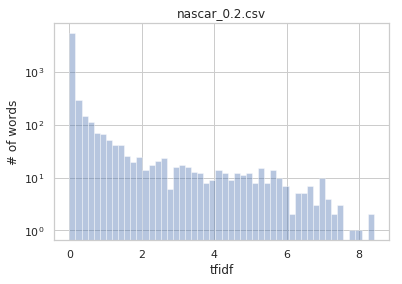

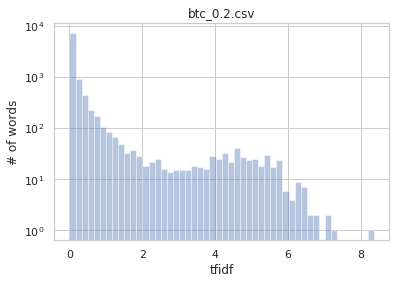

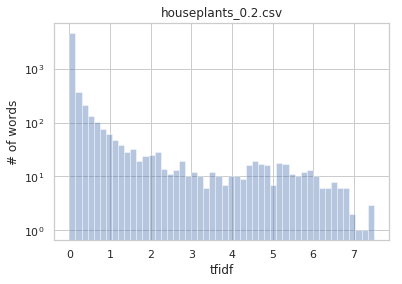

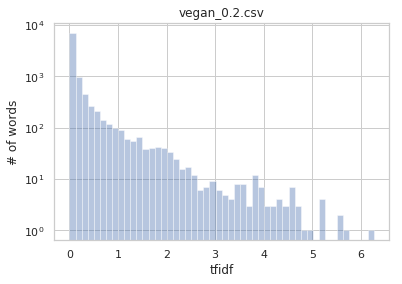

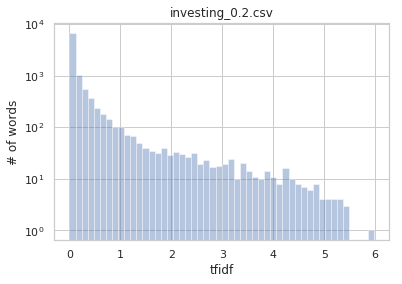

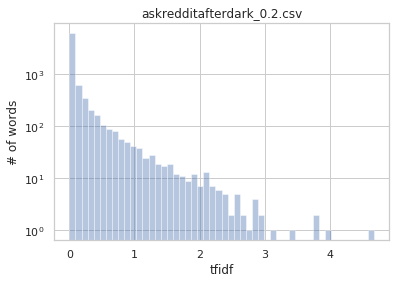

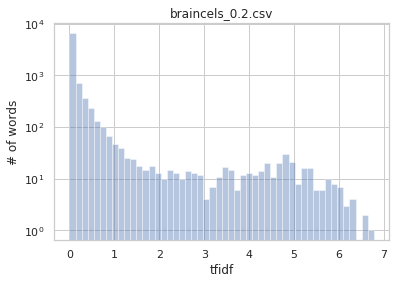

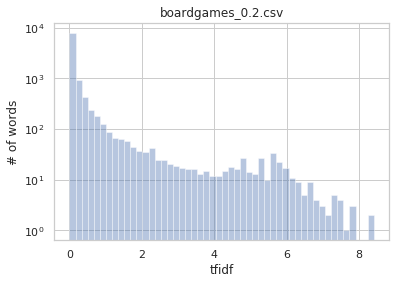

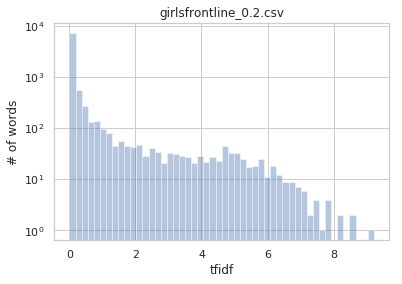

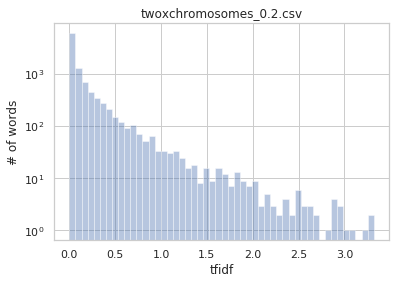

In [16]:
word_choice_hist('tfidf', root+'/logs/tfidf/', 10)

### Size of community vs word choice

In [17]:
def community_size_word_choice(commentor_path, metric_name, path, cut_off, xlabel, scatter=False, 
                               xlog=True, xlim=None): 
    sr_ncoms = pd.read_csv(commentor_path, engine='python').set_index('subreddit').T.to_dict('list')
    suffix = '_0.2.csv'
    y = []
    x = []
    srs = []
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        subreddit = f.replace(suffix, '')
        df = pd.read_csv(path + f, engine='python')
        notable_words = df[df['count'] > count_cut_off]
        num_words = len(notable_words)
        high_val_df = notable_words[notable_words[metric_name] > cut_off]
        num_high_val = len(high_val_df)
        score = num_high_val / float(num_words)
        y.append(score)
        x.append(sr_ncoms[subreddit][0])
        srs.append(subreddit)
    if scatter == True: 
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, alpha=0.5, marker='.')
        if xlog: 
            plt.xscale('log')
    else: 
        if xlog: 
            x = np.log10(x)
        g = sns.jointplot(x, y, kind='hex')
    if xlim: 
        plt.xlim(xlim)
    plt.ylabel(metric_name + ' > ' + str(cut_off) + ' / total words')
    plt.xlabel(xlabel)
    plt.show()

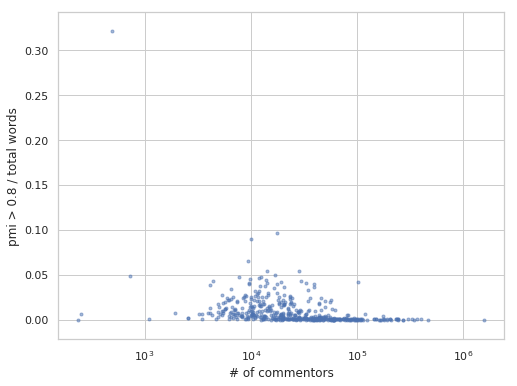

In [18]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
community_size_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', pmi_cut_off, 
                           '# of commentors', scatter=True)

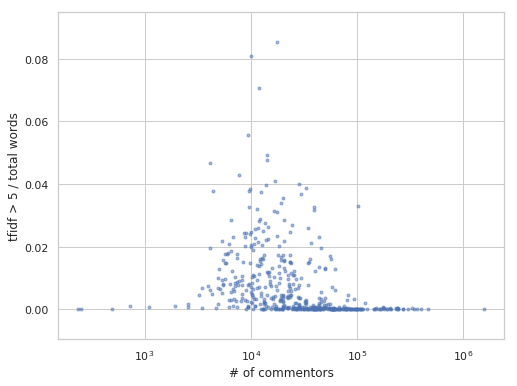

In [19]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
community_size_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', tfidf_cut_off, 
                           '# of commentors', scatter=True)

### User activity vs word choice

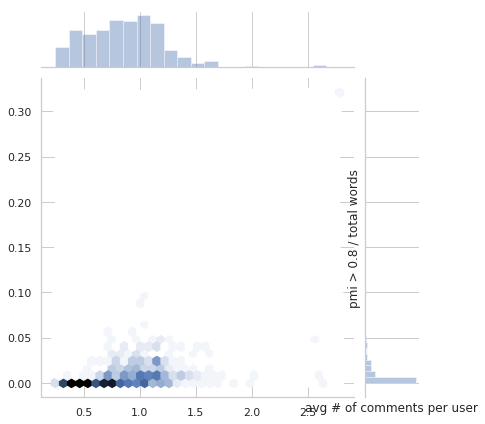

In [20]:
commentor_path = root + 'logs/commentor_activity'
community_size_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', \
                           pmi_cut_off, 'avg # of comments per user')

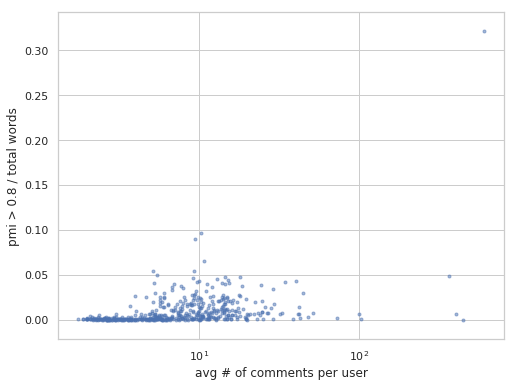

In [21]:
commentor_path = root + 'logs/commentor_activity'
community_size_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', \
                           pmi_cut_off, 'avg # of comments per user', scatter=True)

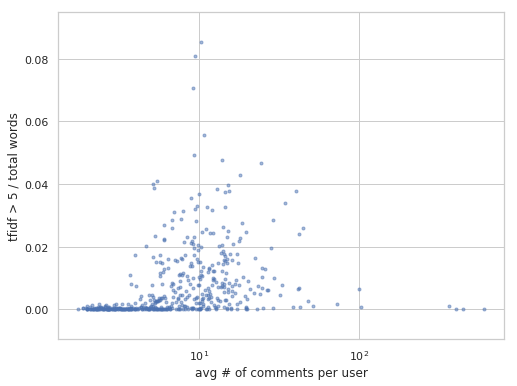

In [22]:
commentor_path = root + 'logs/commentor_activity'
community_size_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', \
                           tfidf_cut_off,  'avg # of comments per user', scatter=True)

### User loyalty vs word choice

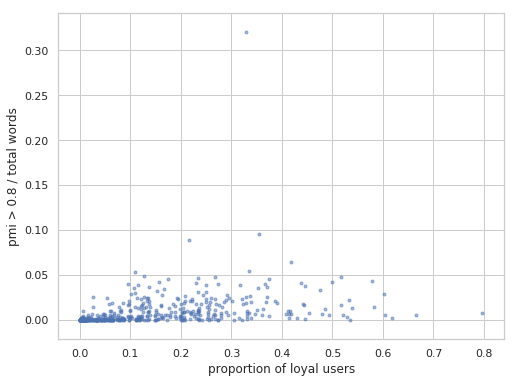

In [23]:
threshold = 50
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
community_size_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', \
                           pmi_cut_off, 'proportion of loyal users', scatter=True, xlog=False)

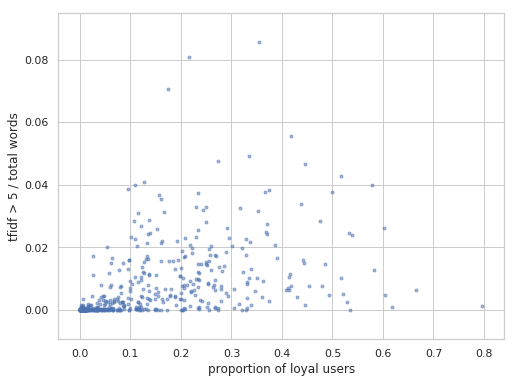

In [24]:
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
community_size_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', \
                           tfidf_cut_off,  'proportion of loyal users', scatter=True, xlog=False)

### User density vs. word choice

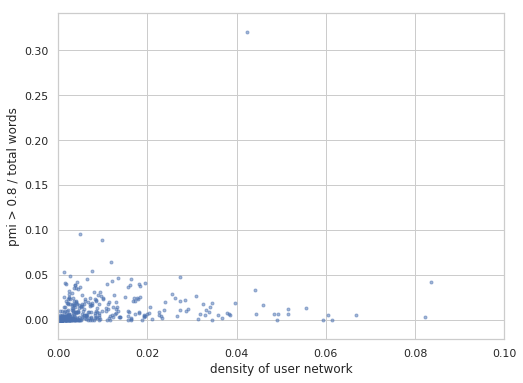

In [25]:
commentor_path = root + 'logs/commentor_density'
community_size_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', \
                           pmi_cut_off, 'density of user network', scatter=True, 
                           xlog=False, xlim=(0, 0.1))

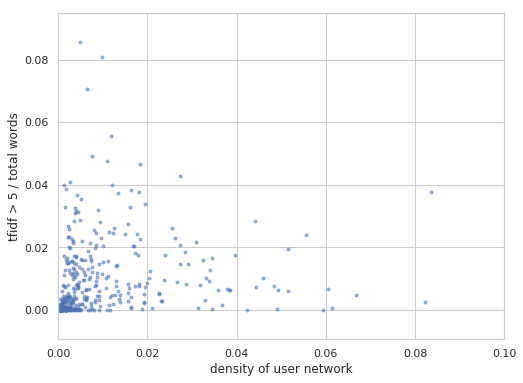

In [26]:
commentor_path = root + 'logs/commentor_density'
community_size_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', \
                           tfidf_cut_off,  'density of user network', scatter=True, 
                           xlog=False, xlim=(0, 0.1))